<a href="https://colab.research.google.com/github/ktichola/Image-matching/blob/main/IMC24_Overlap_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-matching-challenge-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F71885%2F8143495%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T111047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0230fe9cbdeec5a667890bb6a756a7b192023aaa213724f8a51c75f8d71db0cbabf80a4ebe8031b9137e2dfcf8970d0677cc543fa43bd2f0998c7e602d48bb3d9a892a6faed2c83a3ec0c7156994a423cedb9ba4663ac93f2921c0e9d7814db3033485d64463a720f5f1cdfe010a34f8ca86d52c80034bb923fcc4a3c36a2f43a1935a20a545b7981dd981f09892407afa08b3ce11458b87b599c7d59b181ec6a7f6ab769d319f97ec1fb83af86affd88dce723ea17501fbb5921fb788b670a63ddf678d1ad8c2a9ee068874d0c425cd67d258c301e2c547de5f387324640512fa6dd31c34ab301cf0e301083308121f5db7d81b5960798dc78795dda6076105,imc2024-packages-lightglue-rerun-kornia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4628051%2F7884485%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T111047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D27c9d57ef8aaf6f17d1ceb6c4e4f3d88c91280aa7855f26121fc5755f6a8e861002f006dc6375ce0f77093379e5425aa0d6709723246e8d37b2baaae35d190bb7083215501b7ebc1d857ed3a56eff8e577597e9a6d4b9615c6fe7107f71d4d3c8dc21c88cd986774f0580c50a7d8a8ab638e7277b0ccdd6c0e954a93d4822374f73a759db9f4b88df51e3c2ee6223d63ae89cf1f1823b292bd528d84551c5d50a4eba35076dccee387b44e02adcb2614b24f5888514264deeffdd44e2fde64a1c1d90b40a796e3f966dd48c361fc9edce18723d0752fe46d3fecabd2f5f17afc28bfba370e0b73716224cb732608ca02e583cbdcb2544444fa6d624efb73da46,colmap-db-import:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4628331%2F7884725%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T111047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D57aaa1fb4184895684444c7351c7224f376558f9d0ad03f22770b625d8dbe0b560474c963a12f13011ac465a14f46feb8b7d93153a1ca99a9dbdcb1206cc6c3fc5036356d2b1b5fa270590776dc1b3d1da0d0648c84de8b3431217d899f7908ddbf6ef7fed355873fecfd2c344fb6b855ed93301c3b2c33e04cb2a6beabdddebd6e3f0b2032ef107a250c55da44978eb6d17ef5c43c4b7ea3648e18f11a97be29171c93e1792e14d9b0ff015bc3d28a4a7877828ab5a8d1e8d8f50cd268c918fd9600c878c5fe773bd64be4a6e20be3cabd50c5966965b9816812cc377c204b2111a8739484477c903fcaee3ae212957f142f237b2e2d3c4cb0e6daa040044bb,dinov2/pytorch/base/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F3326%2F4534%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T111047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D36c8f51206ee1ffd9e0f70529b9d2032a666a854e1b9abde45b3ff9a3dee06575e5b84ce4f41c867a5da65df01ad71180b1d42f8416d6322f8d842b5c9c74a493e3ad68dce3e67945b243dc0ae2eac99472f173dee38c87bced2a2c0f742eef67ab413341dec605a538ac6bab57f53dece4af1c34ad50f6780e823e0385e3c34238a61ca81b0ee5c827936bf57cf153ae9c797c5ca00e36cf82cbe9c9694734e91937a68fad736e0042f39c9f376efd71272f1c4a6adaaf60432fa1294caab07aef41ad1e311d0b8260bc2f58b84da89d1ee8810d48b68c265a6137a251b3a6b517e938cf6136d8f2b475583672dbdcfcdce45cfb3faf579c7fb25888c9ce6b9,lightglue/pytorch/aliked/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F14317%2F17191%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T111047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7f67125da1f8d36469764dfbe780cc1756c71265e066cbf155b5bb790bddb0f9c00a786906c8b4b040e428c1145d440ff1b65a75e046e2830e2b62a6adc3e42167f31048a66a3e74f0836e9cba7441eba52a73338586c39acc43f8ba1e57dec169f8210fc53fcf0c66d8529648ff72154ec3c05368dfb929d33b570c69d4a9e0da387190fca1f46bec7c348735aafe1bad5d3af7ec83fe47ec3bda446ea41bc9a3f87e43e350e9a2ce740e2984633261dcbf1e911343643997d712cf8b40697014f6b222a08349b395ce5e9847664bdfd60927142524d41f2229cb2453564d48a820bae738baba9271bcca018ecafcada21aac885d9da7e08bf71cfe94d0471c,aliked/pytorch/aliked-n16/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F14611%2F17555%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T111047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D825ce589b73308ea0f7bc7d56b969e4a89f3ec926831a5e9286ce0a8a0ed4ae0e99bff297317363ac547ba75c53ffdba95060cd947d07bc45e7d2fe8eb5fb11028d6841a8eabaf854923ee173e8be668ce602537dbb743c8fc75750c6f2dcdeeb6d5207dcec1091c15109cea89ddab45718baf4ab17b2d22f048235a08f8b24cca03b54dcc3470a4a54f4d2aaaaf66de2a85ba32e4670ae9c73e1c71420d462b18ec5e54a2ed464841ff4060959ed0d7891de9472517ffc8df0dc55aa6281aa66f957beb1cf5093aab8613890f9768754a24816783379642f781aa35e37d896208ec09fa763938f896615c0ea217d0ba07bb5513f58348361c5d6865eabe54c3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# SETUP

In [ ]:
from imc24 import *

# OVERLAP DETECTION

In [ ]:
import torchvision.transforms.functional as TF

m1 = '/kaggle/input/image-matching-challenge-2024/train/church/images/00001.png'
m2 = '/kaggle/input/image-matching-challenge-2024/train/church/images/00002.png'

extractor = ALIKED(max_num_keypoints=4096,detection_threshold=0.01,resize=1080).eval().to(DEVICE)
matcher = KF.LightGlueMatcher("aliked", {'width_confidence':-1, 'depth_confidence':-1, 'mp':True if 'cuda' in str(DEVICE) else False}).eval().to(DEVICE)
image0 = load_image(m1).to(DEVICE)
image1 = load_image(m2).to(DEVICE)
feats0 = extractor.extract(image0)
feats1 = extractor.extract(image1)
kpts0 = feats0["keypoints"]
kpts1 = feats1["keypoints"]
desc0 = feats0["descriptors"].squeeze()
desc1 = feats1["descriptors"].squeeze()
_, matches = matcher(desc0, desc1, KF.laf_from_center_scale_ori(kpts0), KF.laf_from_center_scale_ori(kpts1))
m_kpts0, m_kpts1 = kpts0.squeeze()[matches[..., 0]], kpts1.squeeze()[matches[..., 1]]
left0, top0 = m_kpts0.detach().cpu().numpy().min(axis=0).astype(int)
width0, height0 = m_kpts0.detach().cpu().numpy().max(axis=0).astype(int)
height0 -= top0
width0 -= left0
left1, top1 = m_kpts1.detach().cpu().numpy().min(axis=0).astype(int)
width1, height1 = m_kpts1.detach().cpu().numpy().max(axis=0).astype(int)
height1 -= top1
width1 -= left1
crop_box0 = (top0, left0, height0, width0)
crop_box1 = (top1, left1, height1, width1)
cropped_img_tensor0 = TF.crop(image0, *crop_box0)
cropped_img_tensor1 = TF.crop(image1, *crop_box1)
feats0_c = extractor.extract(cropped_img_tensor0)
feats1_c = extractor.extract(cropped_img_tensor1)
kpts0_c = feats0_c["keypoints"]
kpts1_c = feats1_c["keypoints"]
desc0_c = feats0_c["descriptors"].squeeze()
desc1_c = feats1_c["descriptors"].squeeze()
_, matches_c = matcher(desc0_c, desc1_c, KF.laf_from_center_scale_ori(kpts0_c), KF.laf_from_center_scale_ori(kpts1_c))
kpts0_c[...,0] += left0
kpts0_c[...,1] += top0
kpts1_c[...,0] += left1
kpts1_c[...,1] += top1
m_kpts0_c, m_kpts1_c = kpts0_c.squeeze()[matches_c[..., 0]], kpts1_c.squeeze()[matches_c[..., 1]]
matches_ = torch.cat([matches,matches_c + len(kpts0.squeeze())],axis=0)
kpts0_ = torch.cat([kpts0.squeeze(),kpts0_c.squeeze()],axis=0)
kpts1_ = torch.cat([kpts1.squeeze(),kpts1_c.squeeze()],axis=0)
m_kpts0_, m_kpts1_ = kpts0_.squeeze()[matches_[..., 0]], kpts1_.squeeze()[matches_[..., 1]]

Loaded LightGlue model


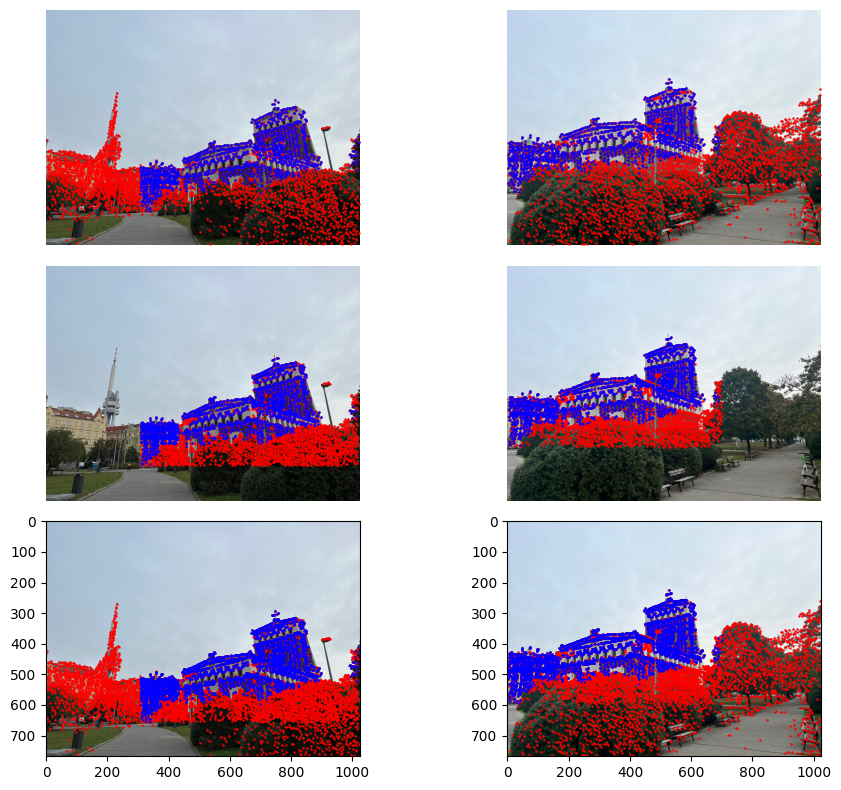

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(10, 8))
ax[0][0].imshow(image0.permute(1,2,0).cpu())
ax[0][0].scatter(kpts0.squeeze()[:, 0].cpu(), kpts0.squeeze()[:, 1].cpu(), s=0.5, c="red")
ax[0][0].scatter(m_kpts0[:, 0].cpu(), m_kpts0[:, 1].cpu(), s=0.5, c="blue")
ax[0][1].imshow(image1.permute(1,2,0).cpu())
ax[0][1].scatter(kpts1.squeeze()[:, 0].cpu(), kpts1.squeeze()[:, 1].cpu(), s=0.5, c="red")
ax[0][1].scatter(m_kpts1[:, 0].cpu(), m_kpts1[:, 1].cpu(), s=0.5, c="blue")

ax[1][0].imshow(image0.permute(1,2,0).cpu())
ax[1][0].scatter(kpts0_c.squeeze()[:, 0].cpu(), kpts0_c.squeeze()[:, 1].cpu(), s=0.5, c="red")
ax[1][0].scatter(m_kpts0_c[:, 0].cpu(), m_kpts0_c[:, 1].cpu(), s=0.5, c="blue")
ax[1][1].imshow(image1.permute(1,2,0).cpu())
ax[1][1].scatter(kpts1_c.squeeze()[:, 0].cpu(), kpts1_c.squeeze()[:, 1].cpu(), s=0.5, c="red")
ax[1][1].scatter(m_kpts1_c[:, 0].cpu(), m_kpts1_c[:, 1].cpu(), s=0.5, c="blue")

ax[2][0].imshow(image0.permute(1,2,0).cpu())
ax[2][0].scatter(kpts0_.squeeze()[:, 0].cpu(), kpts0_.squeeze()[:, 1].cpu(), s=0.5, c="red")
ax[2][0].scatter(m_kpts0_[:, 0].cpu(), m_kpts0_[:, 1].cpu(), s=0.5, c="blue")
ax[2][1].imshow(image1.permute(1,2,0).cpu())
ax[2][1].scatter(kpts1_.squeeze()[:, 0].cpu(), kpts1_.squeeze()[:, 1].cpu(), s=0.5, c="red")
ax[2][1].scatter(m_kpts1_[:, 0].cpu(), m_kpts1_[:, 1].cpu(), s=0.5, c="blue")

ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
plt.tight_layout()

In [ ]:
print(f'Original Matches: {len(matches)}')
print(f'Matches After Overlap Detection: {len(matches_c)}')
print(f'Matches combined: {len(matches) + len(matches_c)}')

Original Matches: 1389
Matches After Overlap Detection: 1947
Matches combined: 3336
